In [35]:
import os
import cv2
import torch
import config
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

In [36]:
import torch.nn as nn


class ConvRNN(nn.Module):

    def __init__(self, n_classes):
        """
        :param n_classes: number of unique characters in the dataset
        """
        super(ConvRNN, self).__init__()

        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.pool_1 = nn.MaxPool2d((2, 2))

        self.conv_2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.pool_2 = nn.MaxPool2d((2, 2))

        self.conv_3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn_3 = nn.BatchNorm2d(256)

        self.conv_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_4 = nn.BatchNorm2d(256)
        self.pool_4 = nn.MaxPool2d((2, 1))

        self.conv_5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn_5 = nn.BatchNorm2d(512)

        self.conv_6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn_6 = nn.BatchNorm2d(512)
        self.pool_6 = nn.MaxPool2d((2, 1))

        self.conv_7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn_7 = nn.BatchNorm2d(512)

        self.linear_1 = nn.Linear(1024, 64)
        self.linear_2 = nn.Linear(64, 64)

        self.rnn_1 = nn.GRU(64, 128, num_layers=2,
                            bidirectional=True,
                            dropout=0.25,
                            batch_first=True)
        self.rnn_2 = nn.GRU(256, 64, num_layers=2,
                            bidirectional=True,
                            dropout=0.25,
                            batch_first=True)

        self.dense = nn.Linear(128, n_classes + 1)

    def forward(self, images):
        x = self.conv_1(images)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.pool_2(x)

        x = self.conv_3(x)
        x = self.bn_3(x)
        x = self.relu(x)

        x = self.conv_4(x)
        x = self.bn_4(x)
        x = self.relu(x)
        x = self.pool_4(x)

        x = self.conv_5(x)
        x = self.bn_5(x)
        x = self.relu(x)

        x = self.conv_6(x)
        x = self.bn_6(x)
        x = self.relu(x)
        x = self.pool_6(x)

        x = self.conv_7(x)
        x = self.bn_7(x)
        x = self.relu(x)

        x = x.view(-1, 512 * 2, 40)
        x = x.permute(0, 2, 1)

        x = self.linear_1(x)
        x = self.relu(x)

        x = self.linear_2(x)
        x = self.relu(x)

        x, _ = self.rnn_1(x)
        x, _ = self.rnn_2(x)

        x = self.dense(x)
        return x


In [37]:
import pickle


def save_obj(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [38]:
import cv2
import torch
import albumentations


class TRSynthDataset(torch.utils.data.Dataset):

    def __init__(self, data_file, char2int):
        """
        :param data_file: pandas dataframe containing the image path and labels
        :param char2int: dictionary mapping every character to an unique integer
        """
        self.image_ids = list(data_file["images"])
        self.labels = list(data_file["labels"])
        self.char2int = char2int
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = albumentations.Compose(
            [albumentations.Normalize(mean, std,
                                      max_pixel_value=255.0,
                                      always_apply=True)]
        )
        self.max_len = data_file["labels"].apply(lambda x: len(x)).max()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Get image id
        img_id = self.image_ids[idx]
        # Load the image
        img = cv2.imread(img_id)
        # Normalize the image
        augmented = self.aug(image=img)
        img = augmented['image']
        # Bring channel first
        img = img.transpose(2, 0, 1)
        # Convert to torch tensor
        img = torch.from_numpy(img)

        # Get the labels
        target = self.labels[idx]
        # Convert characters to integers
        target = [self.char2int[i] for i in target]
        # Length of each target
        target_len = torch.LongTensor([len(target)])
        # Pad target with zeros to make sure every
        # target has equal length
        target += [0] * (self.max_len - len(target))
        # Convert to torch tensor
        target = torch.LongTensor(target)

        return img, target, target_len


In [39]:
epochs = config.epochs
batch_size = config.batch_size
model_path = config.model_path
char2int_path = config.char2int_path
int2char_path = config.int2char_path
data_file_path = config.data_file_path
image_path = config.image_path
label_path = config.label_path

In [40]:
image_path

'D:\\Megha\\PPro\\textdetectioninimage\\data\\data\\images'

### Inspect some images

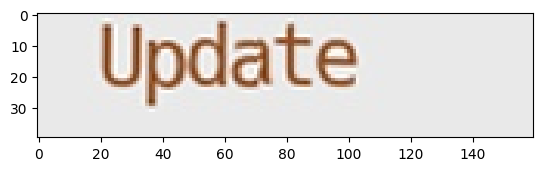

In [41]:
img = plt.imread(os.path.join(image_path,"00000018.jpg"))
plt.imshow(img)
plt.show()

### Check corresponding label

In [42]:
labels = pd.read_table(label_path, header=None)

In [43]:
labels.head()

,0
0,life
1,not
2,while
3,know
4,clearly


In [44]:
labels.iloc[18,0]

'Update'

In [45]:
labels.shape

(100000, 1)

### Total number of images

In [46]:
len(os.listdir(image_path))

100000

### Find null values in labels

In [47]:
labels.isna().sum()

0    6
dtype: int64

In [48]:
labels[labels[0].isna()]

,0
17672,NaN
19198,NaN
33301,NaN
57410,NaN
74347,NaN
77150,NaN


### Let's check those images

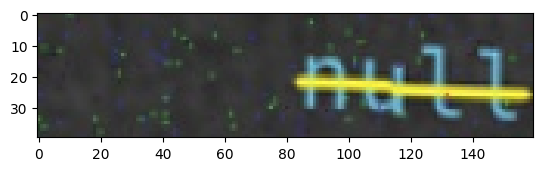

In [49]:
img = plt.imread(os.path.join(image_path, "00019198.jpg"))
plt.imshow(img)
plt.show()

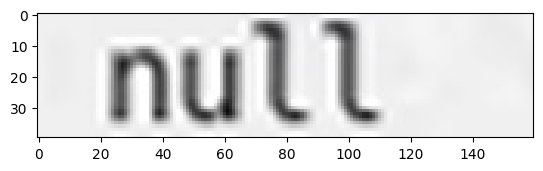

In [50]:
img = plt.imread(os.path.join(image_path, "00074347.jpg"))
plt.imshow(img)
plt.show()

### Replace those missing values with the string "null"

In [51]:
labels.fillna("null", inplace=True)

### Create a dataframe with image paths and corresponding labels

In [52]:
image_files = os.listdir(image_path)
image_files.sort()
image_files = [os.path.join(image_path, i) for i in image_files]

In [53]:
data_file = pd.DataFrame({"images": image_files, "labels": labels[0]})
data_file.to_csv(data_file_path, index=False)

In [54]:
data_file.head()

,images,labels
0,D:\Megha\PPro\textdetectioninimage\data\data\i...,life
1,D:\Megha\PPro\textdetectioninimage\data\data\i...,not
2,D:\Megha\PPro\textdetectioninimage\data\data\i...,while
3,D:\Megha\PPro\textdetectioninimage\data\data\i...,know
4,D:\Megha\PPro\textdetectioninimage\data\data\i...,clearly


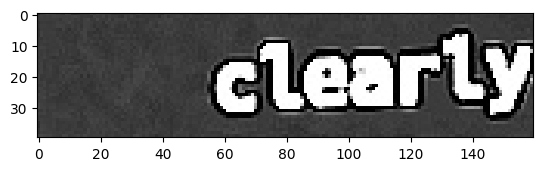

In [55]:
img = plt.imread(os.path.join(image_path, "00000004.jpg"))
plt.imshow(img)
plt.show()

### Find the unique characters in the labels

In [56]:
unique_chars = list({l for word in labels[0] for l in word})
unique_chars.sort()

In [57]:
unique_chars

['#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [58]:
len(unique_chars)

81

### Create mapping from characters to integer and integer to character and save them to dic

In [59]:
char2int = {a: i+1 for i, a in enumerate(unique_chars)}
int2char = {i+1: a for i, a in enumerate(unique_chars)}

In [60]:
save_obj(char2int, char2int_path)
save_obj(int2char, int2char_path)

# Training the model

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")

### Split the data into train and validation

In [62]:
train_file, valid_file = train_test_split(data_file, test_size=0.2)

### Create train and validation datasets

In [63]:
train_dataset = TRSynthDataset(train_file, char2int)
valid_dataset = TRSynthDataset(valid_file, char2int)

### Define the loss function

In [64]:
criterion = nn.CTCLoss(reduction="sum")
criterion.to(device)

CTCLoss()

### Number of classes

In [65]:
n_classes = len(char2int)

### Create the model object

In [66]:
model = ConvRNN(n_classes)
model.to(device)

ConvRNN(
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding

### Define Optimizer

In [67]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)

### Define train and validation data loaders

In [68]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           drop_last=False)

### Training loop

In [69]:
import torch
import config
import numpy as np
import pandas as pd
import torch.nn as nn

from tqdm import tqdm
from sklearn.model_selection import train_test_split


def train(model, dataloader, criterion, device, optimizer=None, test=False):
    """
    Function to train the model
    :param network: Model object
    :param loader: data loader
    :param loss_fn: loss function
    :param dvc: device (cpu or cuda)
    :param opt: optimizer
    :param test: True for validation (gradients won't be updated)
    :return: Average loss for the epoch
    """

    # Set mode to train or validation
    if test:
        model.eval()
    else:
        model.train()
    loss = []
    for inp, tgt, tgt_len in tqdm(dataloader):
        # Move tensors to device
        inp = inp.to(device)
        tgt = tgt.to(device)
        tgt_len = tgt_len.to(device)
        # Forward pass
        out = model(inp)
        out = out.permute(1,0,2)
        # Calculate input lengths for the data points
        # All have equal length of 40 since all images in
        # our dataset are of equal length
        inp_len = torch.LongTensor([40] * out.shape[1])
        # Calculate CTC Loss
        log_probs = nn.functional.log_softmax(out, 2)
        loss_ = criterion(log_probs, tgt, inp_len, tgt_len)

        if not test:
            # Update weights during training
            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

        loss.append(loss_.item())

    return np.mean(loss)


if __name__ == "__main__":

    data_file_path = config.data_file_path
    char2int_path = config.char2int_path
    epochs = config.epochs
    batch_size = config.batch_size
    model_path = config.model_path

    # Read the data file
    data_file = pd.read_csv(data_file_path)
    data_file.fillna("null", inplace=True)

    # Load character to integer mapping dictionary
    char2int = load_obj(char2int_path)

    # Check if cuda is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Split the data into train and validation sets
    train_file, valid_file = train_test_split(data_file, test_size=0.2)

    # Create train and validation datasets
    train_dataset = TRSynthDataset(train_file, char2int)
    valid_dataset = TRSynthDataset(valid_file, char2int)

    # Define loss function
    criterion = nn.CTCLoss(reduction="sum")
    criterion.to(device)

    # Number of classes
    n_classes = len(char2int)
    # Create model object
    model = ConvRNN(n_classes)
    model.to(device)

    # Define optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)

    # Define train and validation dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               drop_last=True)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               drop_last=False)

    # Training loop
    best_loss = 1e7
    for i in range(epochs):
        print(f"Epoch {i+1} of {epochs}...")
        # Run train function
        train_loss = train(model, train_loader, criterion, device, optimizer, test=False)
        # Run validation function
        valid_loss = train(model, valid_loader, criterion, device, test=True)
        print(f"Train Loss: {round(train_loss,4)}, Valid Loss: {round(valid_loss,4)}")
        if valid_loss < best_loss:
            print("Validation Loss improved, saving Model File...")
            # Save model object
            torch.save(model.state_dict(), model_path)
            best_loss = valid_loss


Epoch 1 of 2...


 35%|███▍      | 27679/80000 [1:14:26<2:20:42,  6.20it/s]


KeyboardInterrupt: 

### Load the trained model

In [70]:
model = ConvRNN(n_classes)
model.load_state_dict(torch.load(model_path, 
                                map_location=torch.device('cpu')))

# Set model mode to evaluation
model.eval()

ConvRNN(
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding

# Prediction

### Pick a test image

In [71]:
test_img = os.path.join(image_path, "00000017.jpg")
img = cv2.imread(test_img)

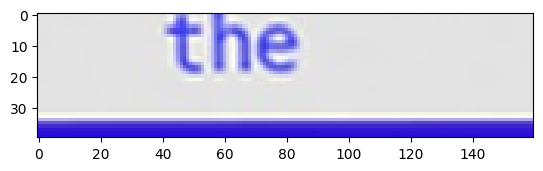

In [72]:
plt.imshow(plt.imread(test_img))
plt.show()

### Apply augmentations

In [73]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
img_aug = albumentations.Compose(
        [albumentations.Normalize(mean, std,
                                  max_pixel_value=255.0,
                                  always_apply=True)]
    )
augmented = img_aug(image=img)
img = augmented["image"]
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img)
# Create batch dimension (batch of single image)
img = torch.unsqueeze(img, 0)
# Move the image array to CUDA if available
img = img.to(device)

### Take model output

In [74]:
out = model(img)

### Apply softmax and take label predictions

In [75]:
out = torch.squeeze(out, 0)
out = out.softmax(1)
pred = torch.argmax(out, 1)

In [76]:
pred.shape

torch.Size([40])

In [77]:
pred = pred.tolist()

In [78]:
pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 75,
 0,
 0,
 63,
 0,
 0,
 0,
 60,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [79]:
int2char[75]

't'

### Use 'ph' for special character

In [80]:
int2char[0] = "ph"

### Convert integer predictions to string

In [81]:
out = [int2char[i] for i in pred]

In [82]:
out

['ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 't',
 'ph',
 'ph',
 'h',
 'ph',
 'ph',
 'ph',
 'e',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph']

### Collapse the output

In [83]:
res = list()
res.append(out[0])
for i in range(1, len(out)):
    if out[i] != out[i - 1]:
        res.append(out[i])
res = [i for i in res if i != "ph"]
res = "".join(res)

In [84]:
print(res)

the
